In [36]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [ ]:
# Check for GPU availability
print("TensorFlow version:", tf.__version__)
print("\nGPU devices:", tf.config.list_physical_devices('GPU'))
print("CPU devices:", tf.config.list_physical_devices('CPU'))

# Try to enable memory growth for GPU if available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"\n✅ GPU memory growth enabled for {len(gpus)} GPU(s)")
    except RuntimeError as e:
        print(f"\n⚠️ Error setting GPU memory growth: {e}")
else:
    print("\n⚠️ No GPU detected - using CPU")

# Building Data Loading Functions

In [38]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])  
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

<img src="Input Preprocessing.png" alt="Input Video Cropping" width="500">


In [39]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [40]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', np.str_('a'), np.str_('b'), np.str_('c'), np.str_('d'), np.str_('e'), np.str_('f'), np.str_('g'), np.str_('h'), np.str_('i'), np.str_('j'), np.str_('k'), np.str_('l'), np.str_('m'), np.str_('n'), np.str_('o'), np.str_('p'), np.str_('q'), np.str_('r'), np.str_('s'), np.str_('t'), np.str_('u'), np.str_('v'), np.str_('w'), np.str_('x'), np.str_('y'), np.str_('z'), np.str_("'"), np.str_('?'), np.str_('!'), np.str_('1'), np.str_('2'), np.str_('3'), np.str_('4'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('8'), np.str_('9'), np.str_(' ')] (size =40)


In [41]:
print(char_to_num(['t','e','a','m','1','0']))
print(num_to_char([1,  2,  3, 4, 5, 6,]))

tf.Tensor([20  5  1 13 30  0], shape=(6,), dtype=int64)
tf.Tensor([b'a' b'b' b'c' b'd' b'e' b'f'], shape=(6,), dtype=string)


In [42]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [45]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    # Use os.path.sep for cross-platform compatibility or split by both / and \
    file_name = path.replace('\\', '/').split('/')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments


In [46]:
test_path = './data/s1/bbaf2n.mpg'

In [47]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').replace('\\', '/').split('/')[-1].split('.')[0]

'bbaf2n'

In [48]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

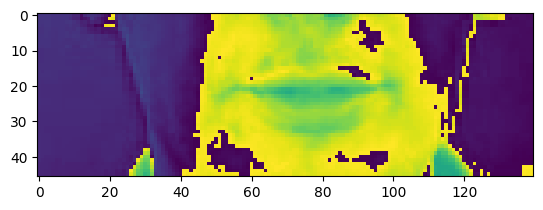

In [49]:
plt.imshow(frames[40])

In [50]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 20, 23, 15,
       39, 14, 15, 23])>

In [51]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>

In [52]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# Data Pipeline - Used for loading Data into the Model

In [53]:
from matplotlib import pyplot as plt

In [54]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(400)
test = data.skip(400)

In [55]:
print("Test Dataset Length =", len(test))

Test Dataset Length = 100


In [56]:
frames, alignments = data.as_numpy_iterator().next() 

In [57]:
print("Number of videos =", len(frames))
print("Corresponding alignments =", alignments)


Number of videos = 2
Corresponding alignments = [[19  5 20 39  2 12 21  5 39  9 14 39 20 39  6 15 21 18 39 16 12  5  1 19
   5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [19  5 20 39  2 12 21  5 39  9 14 39  1 39 20  8 18  5  5 39  1  7  1  9
  14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]


In [58]:
sample = data.as_numpy_iterator()
val = sample.next(); val[0]

array([[[[[ 1.4585044 ],
          [ 1.4585044 ],
          [ 1.4179904 ],
          ...,
          [ 0.12154204],
          [ 0.20257007],
          [ 0.20257007]],

         [[ 1.5395325 ],
          [ 1.4990185 ],
          [ 1.4179904 ],
          ...,
          [ 0.12154204],
          [ 0.20257007],
          [ 0.20257007]],

         [[ 1.4585044 ],
          [ 1.4585044 ],
          [ 1.4585044 ],
          ...,
          [ 0.24308409],
          [ 0.16205606],
          [ 0.16205606]],

         ...,

         [[ 1.0128503 ],
          [ 1.0128503 ],
          [ 1.0128503 ],
          ...,
          [10.250046  ],
          [10.250046  ],
          [10.250046  ]],

         [[ 0.97233635],
          [ 0.97233635],
          [ 0.97233635],
          ...,
          [10.250046  ],
          [10.250046  ],
          [10.250046  ]],

         [[ 0.9318223 ],
          [ 0.9318223 ],
          [ 0.9318223 ],
          ...,
          [10.250046  ],
          [10.250046  ],
          

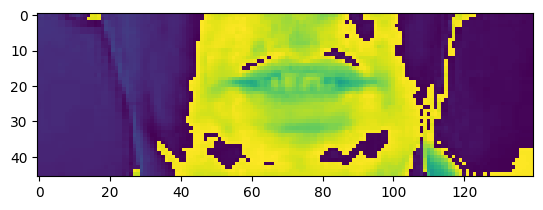

In [59]:
plt.imshow(val[0][0][40])

In [60]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay white in y nine again'>

# 3. Design the Deep Neural Network

In [61]:
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [62]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [63]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))
# 75,23,70,128

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))
# 75,11,35,256

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))
# 75,5,17,75

model.add(TimeDistributed(Flatten()))
# 75, 6375

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))
model.summary()

/Users/nakulbhardwaj/Developer/PersonalProjects/Silent-Speech-Recognition-SpeakSee/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 75, 46, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 75, 46, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 75, 23, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 75, 23, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 23, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 75, 11, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 75, 11, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 75, 11, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 75, 6375)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 75, 256)        │     6,660,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 75, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 75, 41)         │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

<img src="ModelDiag.png" alt="SpeakSee - Model Architecture" width="1350">


In [64]:
print("Input Shape =",model.input_shape)
print("Output Shape =", model.output_shape)

Input Shape = (None, 75, 46, 140, 1)
Output Shape = (None, 75, 41)


In [65]:
yhat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step


In [66]:
tf.argmax(yhat[0],axis=1)

<tf.Tensor: shape=(75,), dtype=int64, numpy=
array([13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0])>

In [67]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'm'>

# 4. Setup Training Options and Train

In [68]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [69]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [70]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [72]:
from tensorflow.keras.optimizers import Adam 
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [74]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint.weights.h5'), monitor='loss', save_weights_only=True) 
schedule_callback = LearningRateScheduler(scheduler)
example_callback = ProduceExample(test)

In [ ]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100


2025-11-27 22:46:57.791602: I external/local_xla/xla/service/service.cc:163] XLA service 0x60001148f300 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-11-27 22:46:57.791802: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1764263817.855295 12939183 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 14/400 ━━━━━━━━━━━━━━━━━━━━ 5:51:55 55s/step - loss: 158.0895

# 5. Make a Prediction 

In [77]:
model.load_weights('models/checkpoint.weights.h5')
# print(model.summary())

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'models/checkpoint.weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [50]:
test_data = test.as_numpy_iterator()
sample = test_data.next()
yhat = model.predict(sample[0])

1/1 [==============================] - 7s 7s/step


In [51]:
print("REAL TEXT:")
real_text = [
    tf.strings.reduce_join([num_to_char(word) for word in sentence]).numpy().decode('utf-8') 
    for sentence in sample[1]
]
print(real_text)

predicted_text = [
    tf.strings.reduce_join([num_to_char(word) for word in np.argmax(pred, axis=-1)]).numpy().decode('utf-8')
    for pred in yhat
]
print("\nPREDICTED TEXT:")
print(predicted_text)


REAL TEXT:
['set green in v zero now', 'place white with r zero please']

PREDICTED TEXT:
['set   green  in   v   zerooo    nnooowwww', 'placce white  withh r   zerooo   ppplleeaassseee']


In [52]:
print('REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'set green in v zero now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place white with r zero please'>]

In [53]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy() # how to the extra letters get removed

In [54]:
print('PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'set green in v zero now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place white with r zero please'>]

In [ ]:
import numpy as np
import tensorflow as tf
from jiwer import wer 

# Load the model weights
model.load_weights('models/checkpoint.weights.h5')
seed = 1
# Initialize lists to store real and predicted texts
all_real_text = []
all_predicted_text = []

# Iterate over all batches in the test dataset
for sample in test:
    # Make a prediction for each batch
    yhat = model.predict(sample[0])

    # Convert real text
    real_text = [
        tf.strings.reduce_join([num_to_char(word) for word in sentence]).numpy().decode('utf-8')
        for sentence in sample[1]
    ]
    all_real_text.extend(real_text)

    # Decode the model predictions
    decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()
    
    # Convert decoded predictions to text
    predicted_text = [
        tf.strings.reduce_join([num_to_char(word) for word in sentence]).numpy().decode('utf-8')
        for sentence in decoded
    ]
    all_predicted_text.extend(predicted_text)

# Calculate Word Error Rate (WER) for the entire dataset
wer_scores = [wer(rt, pt) for rt, pt in zip(all_real_text, all_predicted_text)]
average_wer = np.mean(wer_scores)
print(f"\nAverage WER for the entire dataset: {average_wer:.4f}")

# Calculate simple accuracy (exact match) for the entire dataset
correct_predictions = sum(rt == pt for rt, pt in zip(all_real_text, all_predicted_text))
accuracy = correct_predictions / len(all_real_text)
print(f"Overall Accuracy: {accuracy * 100:.2f}%")


1/1 [==============================] - 3s 3s/step

Average WER for the entire dataset: 0.0129
Overall Accuracy: 93.00%


# Test on a Video

In [52]:
sample = load_data(tf.convert_to_tensor('D:\Python Code\data\s1\srwi4p.mpg'))

In [53]:
print('REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'set red with i four please'>]

In [54]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 2s 2s/step


In [55]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [56]:
print('PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'set red with i four please'>]